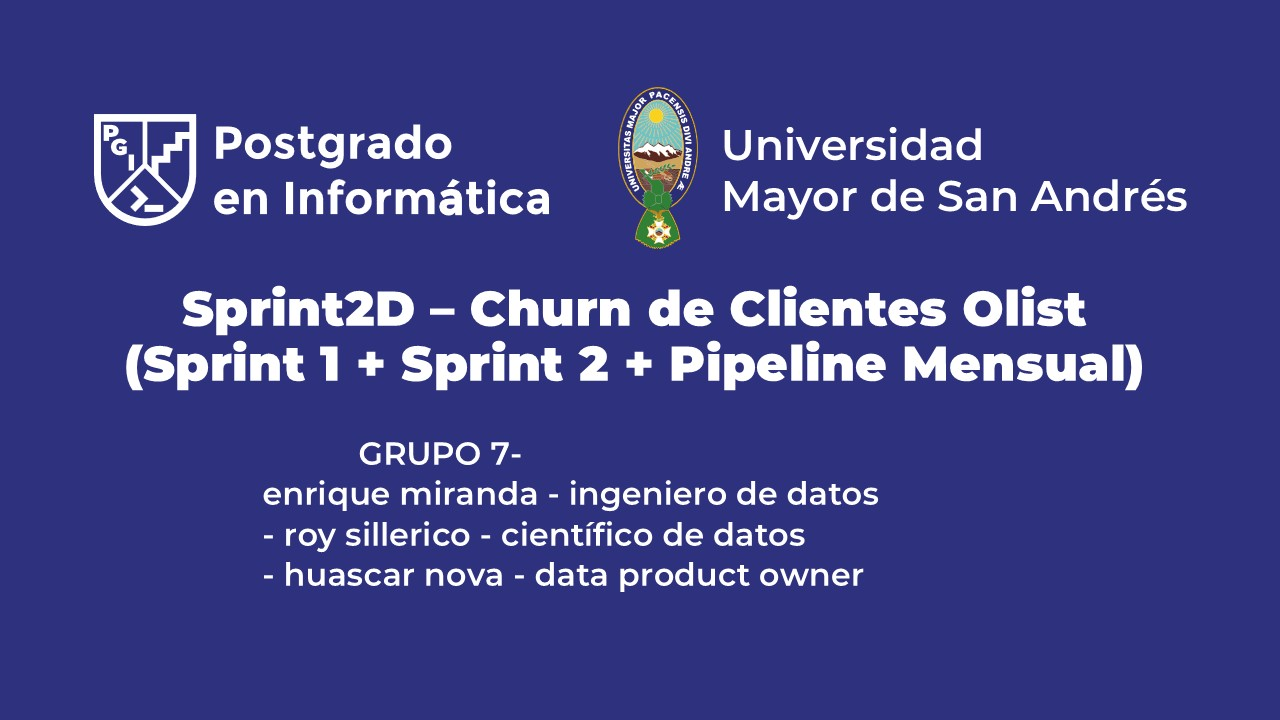

# Sprint2D – Churn de Clientes Olist (Sprint 1 + Sprint 2 + Pipeline Mensual)

Notebook unificado para el proyecto de **Análisis de Churn** usando el dataset público de Olist (marketplace brasileño).

Este notebook integra en un solo flujo:

- **Sprint 1**  
  - Formulación del problema de negocio y del **MVP de churn**.  
  - EDA inicial sobre pedidos y clientes.  
  - Hipótesis de comportamiento de recompra.  
  - Construcción de una primera **tabla maestra** de órdenes.  
  - Definición del **target de churn preliminar** y KPIs base.

- **Sprint 2**  
  - Construcción de un **pipeline reproducible y modular**, parametrizado por período (`YYYY-MM`).  
  - **Data cleaning avanzado**: imputación de nulos y tratamiento de outliers (winsorización p1–p99).  
  - **Feature engineering** a nivel cliente: ~100 variables (RFM extendido, valor económico, logística de entrega, comportamiento de reviews, etc.).  
  - Definición del **target de churn final** a partir de la **distribución real de intervalos entre compras** (percentiles 90 y 99).  
  - Entrenamiento de modelos de clasificación (Regresión Logística y Random Forest) priorizando **recall sobre clientes churn**.  
  - **Selección de variables** usando correlación, Chi², ANOVA y feature importance del Random Forest (modelo full vs modelo reducido).  

- **Simulación mensual y persistencia**  
  - Simulación de incorporación de nuevos datos mediante una **fecha de corte mensual** (`FECHA_CORTE` = último día de cada mes).  
  - Generación de **snapshots mensuales** en formato Parquet:  
    - `orders_enriched_YYYY-MM.parquet` (master de órdenes)  
    - `customer_features_YYYY-MM.parquet` (features a nivel cliente)  
  - Registro histórico de KPIs de churn y métricas de modelo en `processed/metrics/kpis_churn_history.csv`.  
  - Función de **reset de snapshots** para reiniciar el flujo desde cero cuando sea necesario.



---


---



## Índice
1. **Introducción, problema de negocio y objetivo del MVP**  
   - Contexto de negocio de Olist.  
   - Definición del problema de churn y del MVP.  
   - Hipótesis sobre comportamiento de recompra y churn.

2. **Configuración del entorno e imports**  
   - Imports de `pandas`, `numpy`, `matplotlib`, `sklearn`, etc.  
   - Configuración de warnings y formato de impresión.

3. **Montaje de Google Drive (Colab) y rutas de datos**  
   - `drive.mount(...)`.  
   - Definición de `DATA_DIR` y `PROCESSED_DIR`.  
   - Creación de carpetas `master/`, `features/`, `metrics/`.

4. **Carga de datos Olist y tablas base**  
   - Función `load_olist_data(...)`.  
   - Carga de `orders`, `customers`, `order_items`, `order_payments`, `order_reviews`, etc.  
   - Diccionario `data` con todos los DataFrames.

5. **EDA inicial (Sprint 1)**  
   - Rango temporal de `order_purchase_timestamp`.  
   - Conteo de pedidos y clientes.  
   - Función para tabla de valores faltantes.  
   - Distribuciones básicas de estados de orden.

6. **Parámetros del pipeline mensual**  
   - Definición de `PERIODO_OBJETIVO` (YYYY-MM).  
   - Cálculo de `FECHA_CORTE`.  

7. **Funciones del pipeline (limpieza, recorte, master de órdenes)**  
   - `clean_orders`, `clean_customers`, `clean_order_items`, `clean_order_payments`.  
   - `cut_data_to_fecha_corte(...)`.  
   - `build_orders_enriched(...)` (tabla enriquecida a nivel orden).  
   - `get_last_processed_period(...)` para detectar el último período procesado.

8. **Master table por cliente y Feature Engineering (100+ features)**  
   - Función `build_customer_features(...)`.  
   - Agregaciones a nivel `customer_unique_id`: RFM extendido, logística, reviews, importes, estructura de compra, etc.  
   - Construcción de `customer_features`.

8.1 **Análisis del ciclo de recompra (intervalos entre compras)**  
   - Cálculo de `days_between_orders` para clientes con 2+ compras.  
   - Construcción de la serie global de intervalos entre compras.

8.2 **Cálculo de umbrales de recencia para pre-churn y churn final**  
   - Re-cálculo de `days_between_orders`.  
   - Percentiles clave P90 y P99 de los intervalos.  
   - Definición de `CHURN_PRELIM_THRESHOLD` y `CHURN_FINAL_THRESHOLD`.

8.3 **Limpieza avanzada de features de cliente (imputación + outliers)**  
   - Función `clean_customer_features(...)`.  
   - Imputación de nulos numéricos y proporciones.  
   - Winsorización p1–p99 para variables numéricas.  

9. **Definición de target de churn (preliminar y final) + KPIs**  
   - Construcción de `churn_prelim` y `churn_final` usando los umbrales calculados.  
   - Impresión de distribución de churn vs activos.  
   - Cálculo de churn rate y métricas base de clientes.

10. **Preparación de datos y selección de variables (corr con el target)**  
    - Construcción de `X` (numéricas + dummies de `customer_state`) y `y = churn_final`.  
    - Cálculo de correlaciones con el target.  
    - Selección preliminar de variables por |correlación|.  
    - Split `train/test` y escalamiento (`StandardScaler`).

11. **Modelos (Logistic Regression y Random Forest)**  
    - Entrenamiento de Regresión Logística (balanceo de clases).  
    - Entrenamiento de Random Forest.  
    - Reportes de clasificación y ROC–AUC de ambos.  
    - Matrices de confusión.  
    - Importancia de variables del RF.

12. **Métricas de negocio y pruebas Chi² / ANOVA**  
    - Preparación de `X_num` escalado a [0,1].  
    - Test Chi² sobre todas las numéricas.  
    - ANOVA F-test para relación con `churn_final`.  
    - Top variables por Chi² y por F-test.

12.1 **Selección automática de features basada en rankings (Corr, Chi², ANOVA, RF)**  
    - Cálculo de:  
      - Ranking por |correlación|.  
      - Ranking por Chi².  
      - Ranking por ANOVA F-test.  
      - Ranking por importancia de Random Forest.  
    - Unión de los tops y construcción de `selected_features`.

12.2 **Modelo reducido con features seleccionadas y comparación con modelo full**  
    - Definición de `X_full` y `X_reduced`.  
    - Entrenamiento y evaluación de modelos (accuracy, F1, ROC–AUC).  
    - Comparación de desempeño entre modelo completo y reducido.

13. **Función `run_monthly_pipeline()` y persistencia de snapshots**  
    - Pipeline completo por `PERIODO_OBJETIVO`: corte, enriquecimiento, features, limpieza, targets, modelos.  
    - Guardado de Parquets (`master`, `features`) y actualización de métricas históricas.  
    - Control para no reprocesar períodos ya corridos.

13.1 **Simulación de corrida mensual (2018-07)**  
    - Llamada a `run_monthly_pipeline("2018-07", ...)`.  
    - Generación y guardado de resultados para junio + julio.

13.2 **Simulación de corrida mensual (2018-08)**  
    - Llamada a `run_monthly_pipeline("2018-08", ...)`.  
    - Actualización adicional de snapshots y métricas.  

14. **Notas para Git y storytelling**  
    - Qué versionar (notebook, README, diagrama, etc.).  
    - Cómo contar el flujo y las métricas en la exposición.

15. **Reset de snapshots del pipeline (borrar resultados previos)**  
    - Función `reset_processed_outputs(processed_dir)`.  
    - Elimina archivos de `master/`, `features/` y `metrics/` para recomenzar la simulación desde cero.



---


---



## 1. Introducción, problema de negocio y objetivo del MVP

### 1.1 Contexto de negocio

- **Dominio**: Marketplace Olist (Brasil), donde múltiples vendedores (sellers) ofertan productos a clientes finales en todo el país.  
- **Datos disponibles**: transacciones históricas (órdenes, items, pagos, reviews, logística, clientes, sellers, etc.) a lo largo de ~2 años.  
- **Unidad de análisis para churn**: **cliente final**, identificado por `customer_unique_id` (un cliente puede tener varias órdenes en el tiempo).

---

### 1.2 Problema de negocio

Desde el punto de vista comercial, Olist necesita responder de forma mensual a la pregunta:

> **“¿Qué clientes tienen alto riesgo de abandono (churn) y deberían ser priorizados en campañas de retención?”**

Algunos comportamientos que pueden anticipar churn:

- **Alta recencia**: mucho tiempo desde la última compra.  
- **Experiencias logísticas negativas**: retrasos en la entrega, alta proporción de órdenes con demora.  
- **Percepción del servicio**: bajas calificaciones en reviews o alta variabilidad en las mismas.  
- **Baja frecuencia de compra** y poca “vida útil” como cliente.

En resumen, el objetivo no es solo medir quién ya se fue, sino **detectar a tiempo** a quienes están en la zona de riesgo para actuar antes de que abandonen definitivamente.

---

### 1.3 Definición operativa de churn

En este proyecto se define churn de forma **data-driven**, usando la distribución real de **intervalos entre compras**:

1. Se calculan los días entre compras (`days_between_orders`) para clientes con **2 o más órdenes**.  
2. Se analizan cuantitativamente sus estadísticos (mediana, IQR, percentiles 80/90/95/99, máximo).  
3. A partir de esa distribución se definen dos umbrales:

   - **Umbral de pre-churn** (`CHURN_PRELIM_THRESHOLD`):  
     días de recencia por encima del **percentil 90** de `days_between_orders`.  
     → Clientes que ya están “ más lejos de lo normal” y entran a zona de riesgo.

   - **Umbral de churn final** (`CHURN_FINAL_THRESHOLD`):  
     días de recencia por encima del **percentil 99** de `days_between_orders`.  
     → Clientes que están en la cola extrema de la distribución y se consideran **prácticamente perdidos**.

Con estos umbrales se construyen dos targets:

- `churn_prelim`: indicador de **riesgo** (zona amarilla).  
- `churn_final`: indicador de **churn consolidado** (zona roja, cliente casi seguro perdido).

Estos valores **no están quemados** (no son “90 días porque sí”), sino que provienen de la **historia real de recompra** de Olist y pueden recalcularse si se incorpora más data.

---

### 1.4 Objetivo del MVP

El **MVP de churn** consiste en un pipeline que, para cada período objetivo (`PERIODO_OBJETIVO = YYYY-MM`):

1. **Recibe los datos transaccionales de Olist** y los recorta hasta una **fecha de corte mensual** (`FECHA_CORTE` = último día del mes).  
2. Construye una **master table de órdenes** (`orders_enriched`), combinando:  
   `orders` + `customers` + `order_items` + `order_payments` + `order_reviews`, con features de valor, cantidad y tiempos logísticos por pedido.  
3. Agrega esa información a nivel **cliente** (`customer_features`), generando del orden de **100 features**:
   - RFM extendido: `recency_days`, `frequency`, `monetary` (sum, mean, min, max, std, etc.).  
   - Tiempos entre hitos logísticos: compra → aprobación, aprobación → despacho, despacho → entrega, retrasos vs fecha estimada.  
   - Calidad percibida: reviews promedio, variabilidad de reviews.  
   - Estructura de compra: número de items, número de sellers, peso del freight vs precio del producto, etc.
4. Calcula de forma automática los **umbrales de recencia** y define los **targets de churn** (preliminar y final).  
5. Entrena al menos **dos modelos de clasificación** (Regresión Logística y Random Forest), dando prioridad al **recall sobre clientes churn**, para minimizar falsos negativos (churners no detectados).  
6. Calcula y guarda **KPIs de negocio** por mes:  
   - `churn_rate`, `retention_rate`.  
   - Gasto promedio de clientes activos vs churn.  
   - Métricas técnicas de los modelos (accuracy, F1 para clase churn, ROC–AUC).  
7. Persiste los resultados en formato **snapshot mensual**:
   - Parquets por período (`orders_enriched_YYYY-MM`, `customer_features_YYYY-MM`).  
   - Historial de KPIs y métricas en `kpis_churn_history.csv`.

Este MVP permite que, al llegar un nuevo mes, el equipo de negocio/CRM pueda:

- **Ejecutar el pipeline para el nuevo período**,  
- Actualizar automáticamente el listado de clientes en riesgo,  
- Ver la evolución del churn y la retención en el tiempo,  
- Y **entender qué factores (features) están más asociados al abandono** (recency, delays, etc.), apoyándose en los rankings de importancia y en los modelos entrenados.

---

### 1.5 Hipótesis de negocio

Las siguientes hipótesis se formulan a partir del conocimiento del negocio de Olist y de la EDA inicial realizada sobre el histórico de pedidos:

1. **Hipótesis 1 – Recencia y churn**  
   A medida que aumenta el número de días desde la última compra del cliente (`recency_days`), **aumenta la probabilidad de churn**. Clientes que llevan mucho tiempo sin comprar son vistos por el negocio como inactivos o perdidos.

2. **Hipótesis 2 – Frecuencia y valor económico**  
   Clientes con **poca frecuencia de compra** (`frequency` baja) y **bajo valor económico total** (`order_value_sum` bajo) tienen **mayor riesgo de churn** que aquellos que compran más veces y con tickets mayores.

3. **Hipótesis 3 – Comportamiento de pago**  
   Clientes que realizan sus compras con **muchas cuotas** (`avg_installments` alta) y con **tickets promedio más bajos** (`order_value_mean` bajo) tienden a tener **mayor probabilidad de abandono**, porque son compras más esporádicas y de menor compromiso con la plataforma.

4. **Hipótesis 4 – Experiencia de entrega y satisfacción**  
   Peores experiencias logísticas y de servicio se asocian a churn. En particular:  
   - Mayores **retrasos de entrega** (`delivery_delay_days` positivos, `pct_delayed_orders` alto), y  
   - **Puntajes de review más bajos** (`avg_review_score` < 4)  
   se esperan **correlacionar positivamente con el churn**.

5. **Hipótesis 5 – Ubicación geográfica (customer_state)**  
   Determinados estados (`customer_state`) podrían presentar **tasas de churn sistemáticamente más altas** por temas logísticos (distancia, tiempos de entrega, disponibilidad de sellers), por lo que la localización del cliente puede ayudar a explicar el riesgo de abandono.

---

### 1.6 Métricas base del proyecto

En línea con el enunciado del caso de churn mensual, se definen dos grupos de métricas base:

- **Métricas técnicas del modelo (ML)**  
  - **Recall** sobre la clase positiva (churn), para priorizar la detección de clientes en riesgo.  
  - **F1-score**, para balancear precisión y recall.  
  - **ROC-AUC**, como medida global de capacidad discriminativa del modelo.

- **Métricas de negocio (KPIs)**  
  - **Churn rate mensual**: % de clientes que pasan a estado churn en un período.  
  - **Retention rate mensual**: % de clientes que se mantienen activos.  
  - **Gasto promedio por cliente**: ticket promedio de clientes activos vs. churn, para estimar el impacto económico de perder a un cliente.
  
---

---




## 2. Configuración del entorno e imports

In [84]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2, f_classif

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.4f}".format

print("Entorno listo.")


Entorno listo.


## 3. Montaje de Google Drive (Colab) y rutas de datos

In [85]:

from pathlib import Path  # por si no estuviera ya importado arriba

# 🔧 AJUSTA ESTA RUTA A TU CARPETA REAL EN DISCO
# Por ejemplo, si copiaste los CSV a:
# D:\Maestria\M13\Olist
DATA_DIR = Path(r"D:\Maestria\M13\Olist")

print("Archivos encontrados para análisis:")
for f in DATA_DIR.glob("*.csv"):
    print(" -", f.name)

# Carpeta donde se guardarán los resultados del pipeline
PROCESSED_DIR = DATA_DIR / "processed"
(PROCESSED_DIR / "master").mkdir(parents=True, exist_ok=True)
(PROCESSED_DIR / "features").mkdir(parents=True, exist_ok=True)
(PROCESSED_DIR / "metrics").mkdir(parents=True, exist_ok=True)

print("\nCarpetas de salida listas:")
print(" -", PROCESSED_DIR / "master")
print(" -", PROCESSED_DIR / "features")
print(" -", PROCESSED_DIR / "metrics")


Archivos encontrados para análisis:
 - olist_customers_dataset.csv
 - olist_geolocation_dataset.csv
 - olist_orders_dataset.csv
 - olist_order_items_dataset.csv
 - olist_order_payments_dataset.csv
 - olist_order_reviews_dataset.csv
 - olist_products_dataset.csv
 - olist_sellers_dataset.csv
 - product_category_name_translation.csv

Carpetas de salida listas:
 - D:\Maestria\M13\Olist\processed\master
 - D:\Maestria\M13\Olist\processed\features
 - D:\Maestria\M13\Olist\processed\metrics


## 4. Carga de datos Olist y tablas base

In [86]:

def load_olist_data(data_dir: Path) -> dict:
    """Carga los CSV de Olist y devuelve un diccionario de DataFrames."""

    orders = pd.read_csv(
        data_dir / 'olist_orders_dataset.csv',
        parse_dates=[
            'order_purchase_timestamp',
            'order_approved_at',
            'order_delivered_carrier_date',
            'order_delivered_customer_date',
            'order_estimated_delivery_date'
        ]
    )
    customers = pd.read_csv(data_dir / 'olist_customers_dataset.csv')
    order_items = pd.read_csv(
        data_dir / 'olist_order_items_dataset.csv',
        parse_dates=['shipping_limit_date']
    )
    order_payments = pd.read_csv(data_dir / 'olist_order_payments_dataset.csv')
    order_reviews = pd.read_csv(
        data_dir / 'olist_order_reviews_dataset.csv',
        parse_dates=['review_creation_date', 'review_answer_timestamp']
    )
    products = pd.read_csv(data_dir / 'olist_products_dataset.csv')
    sellers = pd.read_csv(data_dir / 'olist_sellers_dataset.csv')
    geolocation = pd.read_csv(data_dir / 'olist_geolocation_dataset.csv')
    prod_cat_trans = pd.read_csv(data_dir / 'product_category_name_translation.csv')

    return {
        'orders': orders,
        'customers': customers,
        'order_items': order_items,
        'order_payments': order_payments,
        'order_reviews': order_reviews,
        'products': products,
        'sellers': sellers,
        'geolocation': geolocation,
        'prod_cat_trans': prod_cat_trans
    }

data = load_olist_data(DATA_DIR)

print("Tablas cargadas:\n")
for name, df in data.items():
    print(f"{name:15s}: {df.shape[0]:7d} filas x {df.shape[1]:2d} columnas")


Tablas cargadas:

orders         :   99441 filas x  8 columnas
customers      :   99441 filas x  5 columnas
order_items    :  112650 filas x  7 columnas
order_payments :  103886 filas x  5 columnas
order_reviews  :   99224 filas x  7 columnas
products       :   32951 filas x  9 columnas
sellers        :    3095 filas x  4 columnas
geolocation    : 1000163 filas x  5 columnas
prod_cat_trans :      71 filas x  2 columnas


## 5. EDA inicial (Sprint 1)

Rango temporal de `order_purchase_timestamp`:
  Mínimo: 2016-09-04 21:15:19
  Máximo: 2018-10-17 17:30:18
  Duración (días): 772

Número de pedidos y clientes:
  Pedidos totales: 99441
  Clientes (customer_id) únicos: 99441
  Clientes (customer_unique_id) únicos: 96096

Valores faltantes en orders:


,missing_count,missing_pct
order_delivered_customer_date,2965,2.9817
order_delivered_carrier_date,1783,1.7930
order_approved_at,160,0.1609



Distribución de `order_status`:


order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

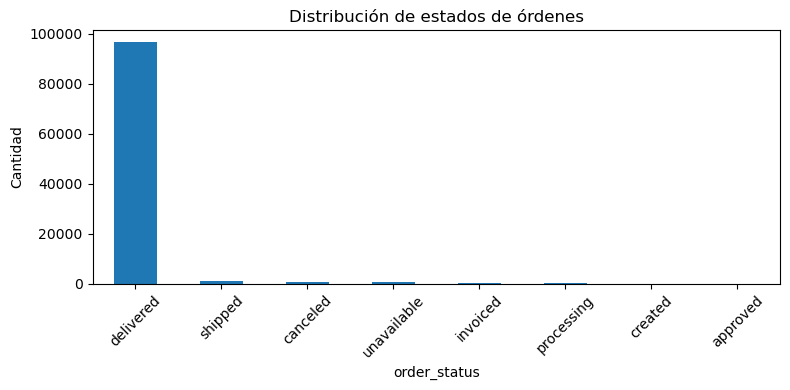

In [87]:

orders = data['orders']
customers = data['customers']

print("Rango temporal de `order_purchase_timestamp`:")
print("  Mínimo:", orders['order_purchase_timestamp'].min())
print("  Máximo:", orders['order_purchase_timestamp'].max())
print("  Duración (días):",
      (orders['order_purchase_timestamp'].max() - orders['order_purchase_timestamp'].min()).days)

print("\nNúmero de pedidos y clientes:")
print("  Pedidos totales:", len(orders))
print("  Clientes (customer_id) únicos:", orders['customer_id'].nunique())
print("  Clientes (customer_unique_id) únicos:", customers['customer_unique_id'].nunique())

def missing_values_table(df: pd.DataFrame, max_rows: int = 20):
    mv = df.isna().sum()
    mv = mv[mv > 0].sort_values(ascending=False)
    res = pd.DataFrame({
        'missing_count': mv,
        'missing_pct': mv / len(df) * 100
    })
    return res.head(max_rows)

print("\nValores faltantes en orders:")
display(missing_values_table(orders))

status_counts = orders['order_status'].value_counts().sort_values(ascending=False)
print("\nDistribución de `order_status`:")
display(status_counts)

plt.figure(figsize=(8, 4))
status_counts.plot(kind='bar')
plt.title('Distribución de estados de órdenes')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 6. Parámetros del pipeline mensual

In [88]:

PERIODO_OBJETIVO = "2018-06"  # YYYY-MM

periodo = pd.Period(PERIODO_OBJETIVO, freq='M')
FECHA_CORTE = periodo.to_timestamp('M')

print(f"PERIODO_OBJETIVO: {PERIODO_OBJETIVO}")
print(f"FECHA_CORTE: {FECHA_CORTE}")


PERIODO_OBJETIVO: 2018-06
FECHA_CORTE: 2018-06-30 00:00:00


## 7. Funciones del pipeline (limpieza, recorte, master de órdenes)

In [89]:

def clean_orders(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df[~df['order_purchase_timestamp'].isna()]
    return df

def clean_customers(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.drop_duplicates(subset=['customer_id'])
    return df

def clean_order_items(df: pd.DataFrame) -> pd.DataFrame:
    return df.copy()

def clean_order_payments(df: pd.DataFrame) -> pd.DataFrame:
    return df.copy()

def clean_order_reviews(df: pd.DataFrame) -> pd.DataFrame:
    return df.copy()

def get_last_processed_period(features_dir: Path):
    pattern = 'customer_features_'
    files = list(features_dir.glob(f'{pattern}*.parquet'))
    if not files:
        return None
    periods = []
    for f in files:
        name = f.stem
        if pattern in name:
            periods.append(name.replace(pattern, ''))
    return max(periods) if periods else None

last_period = get_last_processed_period(PROCESSED_DIR / 'features')
print("Último período procesado encontrado:", last_period)

def cut_data_to_fecha_corte(data_dict: dict, fecha_corte: pd.Timestamp) -> dict:
    orders_all = clean_orders(data_dict['orders'])
    customers_all = clean_customers(data_dict['customers'])
    order_items_all = clean_order_items(data_dict['order_items'])
    order_payments_all = clean_order_payments(data_dict['order_payments'])
    order_reviews_all = clean_order_reviews(data_dict['order_reviews'])

    orders_cut = orders_all[orders_all['order_purchase_timestamp'] <= fecha_corte].copy()

    order_ids = orders_cut['order_id'].unique()
    customer_ids = orders_cut['customer_id'].unique()

    order_items_cut = order_items_all[order_items_all['order_id'].isin(order_ids)].copy()
    order_payments_cut = order_payments_all[order_payments_all['order_id'].isin(order_ids)].copy()
    order_reviews_cut = order_reviews_all[order_reviews_all['order_id'].isin(order_ids)].copy()
    customers_cut = customers_all[customers_all['customer_id'].isin(customer_ids)].copy()

    return {
        'orders': orders_cut,
        'customers': customers_cut,
        'order_items': order_items_cut,
        'order_payments': order_payments_cut,
        'order_reviews': order_reviews_cut
    }

data_cut = cut_data_to_fecha_corte(data, FECHA_CORTE)

print("Tamaños después de FECHA_CORTE:")
for name, df in data_cut.items():
    print(f"{name:15s}: {df.shape[0]:7d} filas x {df.shape[1]:2d} columnas")

def build_orders_enriched(orders, customers, order_items, order_payments, order_reviews):
    df = orders.merge(customers, on='customer_id', how='left')

    payments_agg = order_payments.groupby('order_id').agg(
        total_payment=('payment_value', 'sum'),
        avg_installments=('payment_installments', 'mean')
    ).reset_index()
    df = df.merge(payments_agg, on='order_id', how='left')

    reviews_agg = order_reviews.groupby('order_id').agg(
        avg_review_score=('review_score', 'mean'),
        n_reviews=('review_score', 'size')
    ).reset_index()
    df = df.merge(reviews_agg, on='order_id', how='left')

    items_agg = order_items.groupby('order_id').agg(
        n_items=('order_item_id', 'count'),
        n_sellers=('seller_id', 'nunique'),
        total_items_price=('price', 'sum'),
        total_freight_value=('freight_value', 'sum')
    ).reset_index()
    items_agg['order_value'] = items_agg['total_items_price'] + items_agg['total_freight_value']
    df = df.merge(items_agg, on='order_id', how='left')

    def days_diff(col_end, col_start):
        return (col_end - col_start).dt.total_seconds() / 86400

    df['purchase_to_approval_days'] = days_diff(df['order_approved_at'], df['order_purchase_timestamp'])
    df['approval_to_carrier_days'] = days_diff(df['order_delivered_carrier_date'], df['order_approved_at'])
    df['carrier_to_customer_days'] = days_diff(df['order_delivered_customer_date'], df['order_delivered_carrier_date'])
    df['delivery_delay_days'] = days_diff(df['order_delivered_customer_date'], df['order_estimated_delivery_date'])

    df_completed = df[df['order_status'] == 'delivered'].copy()
    return df_completed

orders_enriched = build_orders_enriched(
    data_cut['orders'],
    data_cut['customers'],
    data_cut['order_items'],
    data_cut['order_payments'],
    data_cut['order_reviews']
)

print("orders_enriched:", orders_enriched.shape)
display(orders_enriched.head())


Último período procesado encontrado: None
Tamaños después de FECHA_CORTE:
orders         :   86493 filas x  8 columnas
customers      :   86493 filas x  5 columnas
order_items    :   98170 filas x  7 columnas
order_payments :   90536 filas x  5 columnas
order_reviews  :   86325 filas x  7 columnas
orders_enriched: (83845, 25)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,n_reviews,n_items,n_sellers,total_items_price,total_freight_value,order_value,purchase_to_approval_days,approval_to_carrier_days,carrier_to_customer_days,delivery_delay_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,1.0000,1.0000,1.0000,29.9900,8.7200,38.7100,0.0074,2.3665,6.0627,-7.1075
1,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,1.0000,1.0000,1.0000,45.0000,27.2000,72.2000,0.0124,3.7458,9.4505,-12.9801
2,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,1.0000,1.0000,1.0000,19.9000,8.7200,28.6200,0.0429,0.8931,1.9378,-9.2382
3,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,...,1.0000,1.0000,1.0000,147.9000,27.3600,175.2600,0.0091,1.6999,14.8332,-5.5431
5,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,...,1.0000,1.0000,1.0000,59.9900,15.1700,75.1600,0.0081,5.8650,4.1167,-11.4612


## 8. Master table por cliente y Feature Engineering (100+ features)

In [90]:

def build_customer_features(orders_enriched: pd.DataFrame, fecha_corte: pd.Timestamp) -> pd.DataFrame:
    df = orders_enriched.copy()

    agg = df.groupby('customer_unique_id').agg({
        'order_purchase_timestamp': ['min', 'max', 'count'],
        'order_value': ['sum', 'mean', 'std', 'min', 'max', 'median'],
        'total_items_price': ['sum', 'mean', 'std', 'min', 'max'],
        'total_freight_value': ['sum', 'mean', 'std', 'min', 'max'],
        'n_items': ['sum', 'mean', 'std', 'min', 'max'],
        'n_sellers': ['sum', 'mean', 'std', 'min', 'max'],
        'total_payment': ['sum', 'mean', 'std', 'min', 'max'],
        'avg_installments': ['mean', 'std', 'min', 'max'],
        'avg_review_score': ['mean', 'std', 'min', 'max'],
        'n_reviews': ['sum', 'mean', 'max'],
        'purchase_to_approval_days': ['mean', 'std', 'min', 'max'],
        'approval_to_carrier_days': ['mean', 'std', 'min', 'max'],
        'carrier_to_customer_days': ['mean', 'std', 'min', 'max'],
        'delivery_delay_days': ['mean', 'std', 'min', 'max',
                                lambda x: (x > 0).sum(),
                                lambda x: (x < 0).sum()]
    }).reset_index()

    agg.columns = [
        '_'.join(col).strip('_') if isinstance(col, tuple) else col
        for col in agg.columns.values
    ]

    rename_map = {
        'order_purchase_timestamp_min': 'first_purchase_date',
        'order_purchase_timestamp_max': 'last_purchase_date',
        'order_purchase_timestamp_count': 'frequency',
        'delivery_delay_days_<lambda_0>': 'num_delayed_orders',
        'delivery_delay_days_<lambda_1>': 'num_early_orders'
    }
    customer_features = agg.rename(columns=rename_map)

    customer_features['recency_days'] = (
        fecha_corte - customer_features['last_purchase_date']
    ).dt.days

    customer_features['customer_lifetime_days'] = (
        customer_features['last_purchase_date'] - customer_features['first_purchase_date']
    ).dt.days

    customer_features['avg_days_between_orders'] = (
        customer_features['customer_lifetime_days'] / (customer_features['frequency'] - 1)
    )
    customer_features['avg_days_between_orders'] = (
        customer_features['avg_days_between_orders']
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0)
    )

    customer_features['pct_delayed_orders'] = (
        customer_features['num_delayed_orders'] / customer_features['frequency']
    ).fillna(0)

    customer_features['pct_early_orders'] = (
        customer_features['num_early_orders'] / customer_features['frequency']
    ).fillna(0)

    customer_features['freight_ratio_total'] = (
        customer_features['total_freight_value_sum'] /
        customer_features['order_value_sum']
    ).replace([np.inf, -np.inf], np.nan).fillna(0)

    customer_features['avg_price_per_item'] = (
        customer_features['total_items_price_sum'] /
        customer_features['n_items_sum']
    ).replace([np.inf, -np.inf], np.nan).fillna(0)

    state_series = (
        df.groupby('customer_unique_id')['customer_state']
          .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    )
    customer_features = customer_features.merge(
        state_series.reset_index(),
        on='customer_unique_id',
        how='left'
    )

    print("Número total de variables (columnas):", customer_features.shape[1])
    return customer_features

customer_features = build_customer_features(orders_enriched, FECHA_CORTE)
print("customer_features:", customer_features.shape)
display(customer_features.head())


Número total de variables (columnas): 72
customer_features: (81147, 72)


,customer_unique_id,first_purchase_date,last_purchase_date,frequency,order_value_sum,order_value_mean,order_value_std,order_value_min,order_value_max,order_value_median,...,num_delayed_orders,num_early_orders,recency_days,customer_lifetime_days,avg_days_between_orders,pct_delayed_orders,pct_early_orders,freight_ratio_total,avg_price_per_item,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1,141.9000,141.9000,NaN,141.9000,141.9000,141.9000,...,0,1,50,0,0.0000,0.0000,1.0000,0.0846,129.9000,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1,27.1900,27.1900,NaN,27.1900,27.1900,27.1900,...,0,1,53,0,0.0000,0.0000,1.0000,0.3049,18.9000,SP
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1,86.2200,86.2200,NaN,86.2200,86.2200,86.2200,...,0,1,476,0,0.0000,0.0000,1.0000,0.1997,69.0000,SC
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1,43.6200,43.6200,NaN,43.6200,43.6200,43.6200,...,0,1,260,0,0.0000,0.0000,1.0000,0.4042,25.9900,PA
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1,196.8900,196.8900,NaN,196.8900,196.8900,196.8900,...,0,1,227,0,0.0000,0.0000,1.0000,0.0858,180.0000,SP


## 8.1 Análisis del ciclo de recompra (intervalos entre compras)

Resumen de intervalos entre compras (solo clientes con 2+ órdenes):
  • Número de intervalos           : 2,698
  • Clientes con 2+ compras        : 2,421

Estadísticos de days_between_orders (en días):
  Q1 (25%)           :    0.0
  Mediana (50%)      :   24.0
  Q3 (75%)           :  108.0
  IQR (Q3 - Q1)      :  108.0
  Percentil 80       :  134.0
  Percentil 90       :  214.3
  Percentil 95       :  291.5
  Percentil 99       :  397.0
  Máximo observado   :  608.0


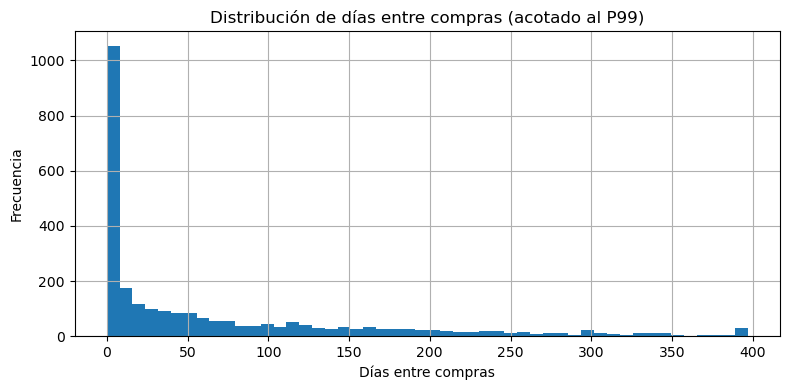

In [91]:
# 8.1 Cálculo de intervalos entre compras por cliente

# Usamos orders_enriched (solo órdenes entregadas hasta FECHA_CORTE)
df_intervals = orders_enriched[['customer_unique_id', 'order_purchase_timestamp']].copy()

# Ordenar por cliente y fecha de compra
df_intervals = df_intervals.sort_values(
    ['customer_unique_id', 'order_purchase_timestamp']
)

# Fecha de la siguiente compra por cliente
df_intervals['next_purchase_timestamp'] = (
    df_intervals
    .groupby('customer_unique_id')['order_purchase_timestamp']
    .shift(-1)
)

# Días entre una compra y la siguiente
df_intervals['days_between_orders'] = (
    df_intervals['next_purchase_timestamp'] - df_intervals['order_purchase_timestamp']
).dt.days

# Nos quedamos solo con intervalos válidos (no nulos y no negativos)
intervals = df_intervals.dropna(subset=['days_between_orders']).copy()
intervals = intervals[intervals['days_between_orders'] >= 0]

# Serie global que usaremos en el siguiente bloque
days_between_orders = intervals['days_between_orders']

n_intervals = len(days_between_orders)
n_clients_multi_orders = intervals['customer_unique_id'].nunique()

print("Resumen de intervalos entre compras (solo clientes con 2+ órdenes):")
print(f"  • Número de intervalos           : {n_intervals:,}")
print(f"  • Clientes con 2+ compras        : {n_clients_multi_orders:,}")

# Estadísticos básicos
q1 = days_between_orders.quantile(0.25)
median = days_between_orders.quantile(0.50)
q3 = days_between_orders.quantile(0.75)
iqr = q3 - q1
p80 = days_between_orders.quantile(0.80)
p90 = days_between_orders.quantile(0.90)
p95 = days_between_orders.quantile(0.95)
p99 = days_between_orders.quantile(0.99)

print("\nEstadísticos de days_between_orders (en días):")
print(f"  Q1 (25%)           : {q1:6.1f}")
print(f"  Mediana (50%)      : {median:6.1f}")
print(f"  Q3 (75%)           : {q3:6.1f}")
print(f"  IQR (Q3 - Q1)      : {iqr:6.1f}")
print(f"  Percentil 80       : {p80:6.1f}")
print(f"  Percentil 90       : {p90:6.1f}")
print(f"  Percentil 95       : {p95:6.1f}")
print(f"  Percentil 99       : {p99:6.1f}")
print(f"  Máximo observado   : {days_between_orders.max():6.1f}")

# Histograma acotado al P99 para evitar la cola muy larga
plt.figure(figsize=(8, 4))
upper = days_between_orders.quantile(0.99)
days_between_orders.clip(upper=upper).hist(bins=50)
plt.title('Distribución de días entre compras (acotado al P99)')
plt.xlabel('Días entre compras')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

## 8.2 Cálculo de umbrales de recencia para pre-churn y churn final

In [92]:
# 8.2) Definición de umbrales de recencia (pre-churn y churn final, 100% data-driven)

print("8.2) Definición de umbrales de recencia (pre-churn y churn final)\n")

# Recalculamos los intervalos entre compras por cliente
df_sorted = orders_enriched.sort_values(
    ["customer_unique_id", "order_purchase_timestamp"]
).copy()

df_sorted["next_purchase"] = df_sorted.groupby("customer_unique_id")[
    "order_purchase_timestamp"
].shift(-1)

df_sorted["days_between_orders"] = (
    df_sorted["next_purchase"] - df_sorted["order_purchase_timestamp"]
).dt.days

intervals = df_sorted["days_between_orders"].dropna()

# Percentiles clave de los intervalos entre compras
p90 = np.percentile(intervals, 90)
p99 = np.percentile(intervals, 99)

CHURN_PRELIM_THRESHOLD = int(round(p90))   # pre-churn
CHURN_FINAL_THRESHOLD = int(round(p99))   # churn final (casos extremos)

print("Umbrales de recencia calculados (en días, usando distribución de intervalos entre compras):")
print(f"  • Pre-churn  (percentil 90) : {CHURN_PRELIM_THRESHOLD} días")
print(f"  • Churn final (percentil 99): {CHURN_FINAL_THRESHOLD} días")

print("\nEstos valores reemplazan a los 90 y 365 fijos; ahora ambos salen de la distribución real de días entre compras.")

8.2) Definición de umbrales de recencia (pre-churn y churn final)

Umbrales de recencia calculados (en días, usando distribución de intervalos entre compras):
  • Pre-churn  (percentil 90) : 214 días
  • Churn final (percentil 99): 397 días

Estos valores reemplazan a los 90 y 365 fijos; ahora ambos salen de la distribución real de días entre compras.


# 8.3 Limpieza avanzada de features de cliente (imputación + outliers)

In [93]:
# 8.3 Limpieza avanzada de features de cliente (imputación + outliers)

def clean_customer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Limpieza avanzada de customer_features:
      - Imputación de valores faltantes.
      - Tratamiento simple de outliers (winsorización p1–p99).
    """
    df_clean = df.copy()

    # Columnas numéricas
    num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

    # Porcentajes (0–1) tipo pct_delayed_orders, pct_early_orders, etc.
    pct_cols = [c for c in num_cols if c.startswith('pct_')]

    # Columnas de conteo (frecuencia, números de items, sellers, etc.)
    count_patterns = ['frequency', 'num_', 'n_items', 'n_sellers']
    count_cols = [
        c for c in num_cols
        if any(pat in c for pat in count_patterns) and c not in pct_cols
    ]

    # Continuas: montos, días, promedios, ratios, etc.
    continuous_cols = [
        c for c in num_cols
        if c not in pct_cols and c not in count_cols
    ]

    # --- Imputación de nulos ---
    nulls_before = df_clean[num_cols].isna().sum().sum()

    # Continuas → mediana
    for col in continuous_cols:
        if df_clean[col].isna().any():
            med = df_clean[col].median()
            df_clean[col].fillna(med, inplace=True)

    # Contadores → 0
    for col in count_cols:
        if df_clean[col].isna().any():
            df_clean[col].fillna(0, inplace=True)

    # Porcentajes → 0 y acotar a [0,1]
    for col in pct_cols:
        if df_clean[col].isna().any():
            df_clean[col].fillna(0, inplace=True)
        df_clean[col] = df_clean[col].clip(lower=0, upper=1)

    # Categórica básica
    if 'customer_state' in df_clean.columns:
        df_clean['customer_state'] = df_clean['customer_state'].fillna('UNKNOWN')

    # --- Tratamiento de outliers (winsorización p1–p99) ---
    clipped_total_low = 0
    clipped_total_high = 0

    for col in continuous_cols:
        q1 = df_clean[col].quantile(0.01)
        q99 = df_clean[col].quantile(0.99)
        col_before = df_clean[col].copy()

        df_clean[col] = df_clean[col].clip(lower=q1, upper=q99)

        clipped_low = (col_before < q1).sum()
        clipped_high = (col_before > q99).sum()
        clipped_total_low += clipped_low
        clipped_total_high += clipped_high

    nulls_after = df_clean[num_cols].isna().sum().sum()

    print("\n[Clean] Resumen de limpieza avanzada de customer_features")
    print("  • Nulos numéricos antes :", int(nulls_before))
    print("  • Nulos numéricos después:", int(nulls_after))
    print("  • Valores recortados por abajo (p1) :", int(clipped_total_low))
    print("  • Valores recortados por arriba (p99):", int(clipped_total_high))

    return df_clean


# Aplicar la limpieza al dataset de clientes
customer_features = clean_customer_features(customer_features)

print("\ncustomer_features después de la limpieza avanzada:")
print(f"  Filas: {customer_features.shape[0]}, Columnas: {customer_features.shape[1]}")



[Clean] Resumen de limpieza avanzada de customer_features
  • Nulos numéricos antes : 947607
  • Nulos numéricos después: 0
  • Valores recortados por abajo (p1) : 28395
  • Valores recortados por arriba (p99): 37768

customer_features después de la limpieza avanzada:
  Filas: 81147, Columnas: 72


## 9. Definición de target de churn (preliminar y final) + KPIs

In [94]:

# 9. Definición de target de churn (preliminar y final) + KPIs (usando thresholds calculados)

# Aseguramos que los thresholds vienen de la sección 8.2
try:
    CHURN_PRELIM_THRESHOLD
    CHURN_FINAL_THRESHOLD
except NameError:
    raise RuntimeError(
        "CHURN_PRELIM_THRESHOLD / CHURN_FINAL_THRESHOLD no están definidos. "
        "Ejecuta primero las secciones 8.1 y 8.2."
    )

print("Thresholds de recencia utilizados (en días):")
print(f"  • Pre-churn  : {CHURN_PRELIM_THRESHOLD}")
print(f"  • Churn final: {CHURN_FINAL_THRESHOLD}")

# Crear targets en base a recency_days y los umbrales calculados
customer_features['churn_prelim'] = (
    customer_features['recency_days'] > CHURN_PRELIM_THRESHOLD
).astype(int)

customer_features['churn_final'] = (
    customer_features['recency_days'] > CHURN_FINAL_THRESHOLD
).astype(int)

def print_churn_distribution(df_cf: pd.DataFrame, label_col: str):
    """Imprime distribución de una variable binaria de churn."""
    churn_count = df_cf[label_col].sum()
    total = len(df_cf)
    active_count = total - churn_count
    churn_rate = churn_count / total * 100
    print(f"Target: {label_col}")
    print(f"  Clientes totales : {total:6d}")
    print(f"  Churned (1)      : {churn_count:6d} ({churn_rate:5.1f}%)")
    print(f"  Activos  (0)     : {active_count:6d} ({100 - churn_rate:5.1f}%)\n")

print("\nDistribución de targets con umbrales calculados:\n")
print_churn_distribution(customer_features, 'churn_prelim')
print_churn_distribution(customer_features, 'churn_final')

# Target principal para modelado
TARGET_COL = 'churn_final'

def compute_basic_kpis(df_cf: pd.DataFrame, target_col: str) -> dict:
    """KPIs básicos de negocio a nivel cliente."""
    churn_rate = df_cf[target_col].mean()
    retention_rate = 1 - churn_rate
    clientes_totales = len(df_cf)
    clientes_churn = int(df_cf[target_col].sum())
    clientes_activos = int(clientes_totales - clientes_churn)

    avg_monetary = df_cf['order_value_sum'].mean()
    active_monetary = df_cf.loc[df_cf[target_col] == 0, 'order_value_sum'].mean()
    churned_monetary = df_cf.loc[df_cf[target_col] == 1, 'order_value_sum'].mean()

    res = {
        'clientes_totales': clientes_totales,
        'clientes_churn': clientes_churn,
        'clientes_activos': clientes_activos,
        'churn_rate': churn_rate,
        'retention_rate': retention_rate,
        'avg_monetary_total': avg_monetary,
        'avg_monetary_activos': active_monetary,
        'avg_monetary_churn': churned_monetary
    }

    print("KPIs de negocio (con target churn_final):")
    print(f"  • Churn rate      : {churn_rate*100:5.2f}%")
    print(f"  • Retention rate  : {retention_rate*100:5.2f}%")
    print(f"  • Gasto promedio total  : {avg_monetary:,.2f}")
    print(f"  • Gasto promedio activos: {active_monetary:,.2f}")
    print(f"  • Gasto promedio churn  : {churned_monetary:,.2f}")
    return res

kpis_base = compute_basic_kpis(customer_features, TARGET_COL)

Thresholds de recencia utilizados (en días):
  • Pre-churn  : 214
  • Churn final: 397

Distribución de targets con umbrales calculados:

Target: churn_prelim
  Clientes totales :  81147
  Churned (1)      :  35185 ( 43.4%)
  Activos  (0)     :  45962 ( 56.6%)

Target: churn_final
  Clientes totales :  81147
  Churned (1)      :  10070 ( 12.4%)
  Activos  (0)     :  71077 ( 87.6%)

KPIs de negocio (con target churn_final):
  • Churn rate      : 12.41%
  • Retention rate  : 87.59%
  • Gasto promedio total  : 159.06
  • Gasto promedio activos: 159.03
  • Gasto promedio churn  : 159.29


## 10. Preparación de datos y selección de variables

Top 15 correlaciones (|corr|):
  delivery_delay_days_max            : -0.142 (DÉBIL)
  delivery_delay_days_mean           : -0.141 (DÉBIL)
  delivery_delay_days_min            : -0.138 (DÉBIL)
  num_delayed_orders                 : -0.046 (DÉBIL)
  pct_delayed_orders                 : -0.045 (DÉBIL)
  pct_early_orders                   : +0.045 (DÉBIL)
  customer_lifetime_days             : -0.040 (DÉBIL)
  avg_days_between_orders            : -0.039 (DÉBIL)
  carrier_to_customer_days_max       : -0.029 (DÉBIL)
  n_sellers_sum                      : -0.027 (DÉBIL)
  carrier_to_customer_days_mean      : -0.027 (DÉBIL)
  approval_to_carrier_days_min       : +0.027 (DÉBIL)
  num_early_orders                   : +0.026 (DÉBIL)
  approval_to_carrier_days_mean      : +0.026 (DÉBIL)
  purchase_to_approval_days_std      : -0.025 (DÉBIL)


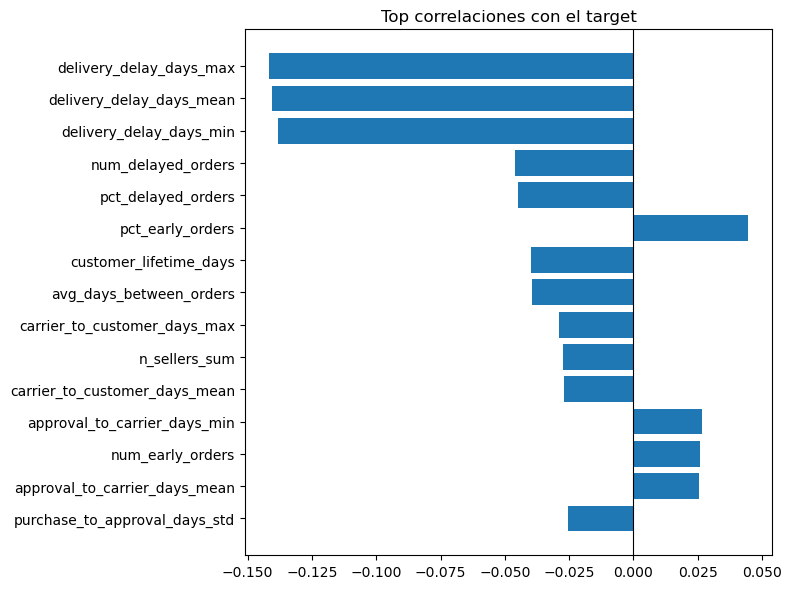

Shape de X, y: (81147, 93) (81147,)
Train / Test listos.


In [95]:

numeric_vars = [
    col for col in customer_features.select_dtypes(include=[np.number]).columns
    if col not in ['churn_prelim', 'churn_final', 'recency_days']
]

corr_rows = []
for var in numeric_vars:
    corr = customer_features[[var, TARGET_COL]].corr().iloc[0, 1]
    corr_rows.append({'Variable': var, 'Correlation': corr, 'Abs': abs(corr)})

corr_df = (
    pd.DataFrame(corr_rows)
    .dropna()
    .sort_values('Abs', ascending=False)
)

print("Top 15 correlaciones (|corr|):")
for _, row in corr_df.head(15).iterrows():
    strength = "FUERTE" if abs(row['Correlation']) > 0.5 else                    "MODERADA" if abs(row['Correlation']) > 0.3 else "DÉBIL"
    print(f"  {row['Variable']:35s}: {row['Correlation']:+.3f} ({strength})")

top_corr = corr_df.head(15)
plt.figure(figsize=(8, 6))
plt.barh(top_corr['Variable'], top_corr['Correlation'])
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Top correlaciones con el target')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

feature_cols_numeric = numeric_vars
feature_cols_categ = ['customer_state']

X_num = customer_features[feature_cols_numeric].fillna(0)
X_cat = pd.get_dummies(customer_features[feature_cols_categ], drop_first=True)

X = pd.concat([X_num, X_cat], axis=1)
y = customer_features[TARGET_COL]

print("Shape de X, y:", X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train / Test listos.")


## 11. Modelos (Logistic Regression y Random Forest)

Reporte – Regresión Logística
              precision    recall  f1-score   support

           0      0.912     0.645     0.755     21324
           1      0.183     0.563     0.276      3021

    accuracy                          0.634     24345
   macro avg      0.548     0.604     0.516     24345
weighted avg      0.822     0.634     0.696     24345

ROC-AUC: 0.6511582990845486


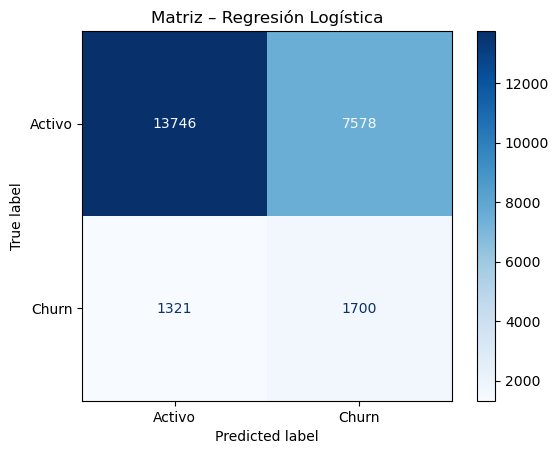

Reporte – Random Forest
              precision    recall  f1-score   support

           0      0.907     0.997     0.950     21324
           1      0.929     0.281     0.432      3021

    accuracy                          0.908     24345
   macro avg      0.918     0.639     0.691     24345
weighted avg      0.910     0.908     0.886     24345

ROC-AUC: 0.8835319104665391


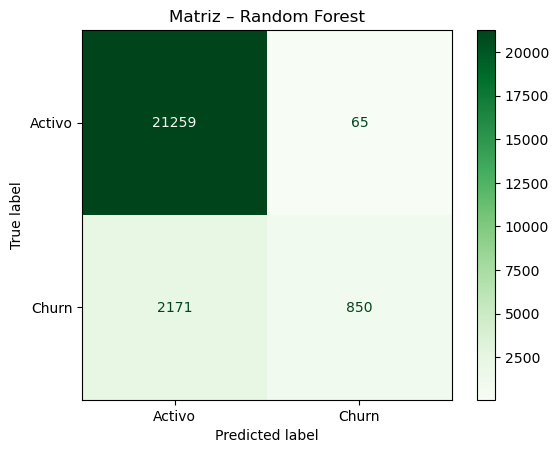


Top 20 variables más importantes (RF):


,importance
purchase_to_approval_days_mean,0.0683
purchase_to_approval_days_max,0.0628
purchase_to_approval_days_min,0.0615
delivery_delay_days_max,0.0553
delivery_delay_days_min,0.0534
delivery_delay_days_mean,0.0513
total_freight_value_min,0.0363
total_freight_value_max,0.0363
total_freight_value_mean,0.0358
total_freight_value_sum,0.0343


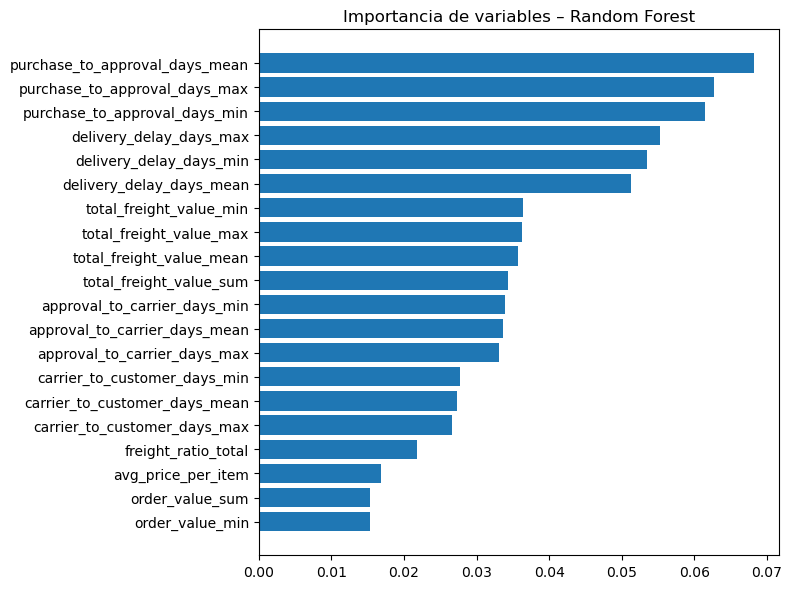

KPIs de modelado: {'roc_auc_lr': 0.6511582990845486, 'roc_auc_rf': 0.8835319104665391}


In [96]:

# Regresión Logística
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Reporte – Regresión Logística")
print(classification_report(y_test, y_pred_lr, digits=3))
roc_lr = roc_auc_score(y_test, y_proba_lr)
print("ROC-AUC:", roc_lr)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lr,
    display_labels=['Activo', 'Churn'],
    cmap='Blues'
)
plt.title('Matriz – Regresión Logística')
plt.show()

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Reporte – Random Forest")
print(classification_report(y_test, y_pred_rf, digits=3))
roc_rf = roc_auc_score(y_test, y_proba_rf)
print("ROC-AUC:", roc_rf)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf,
    display_labels=['Activo', 'Churn'],
    cmap='Greens'
)
plt.title('Matriz – Random Forest')
plt.show()

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 20 variables más importantes (RF):")
display(importances.head(20).to_frame('importance'))

top_imp = importances.head(20)
plt.figure(figsize=(8, 6))
plt.barh(top_imp.index, top_imp.values)
plt.title('Importancia de variables – Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

kpis_modelado = {
    'roc_auc_lr': roc_lr,
    'roc_auc_rf': roc_rf
}
print("KPIs de modelado:", kpis_modelado)


## 12. Métricas de negocio y pruebas Chi² / ANOVA

In [97]:

X_num = customer_features[numeric_vars].fillna(0)
mm_scaler = MinMaxScaler()
X_chi2 = mm_scaler.fit_transform(X_num)

chi2_vals, chi2_p = chi2(X_chi2, y)
chi2_results = pd.DataFrame({
    'feature': numeric_vars,
    'chi2_stat': chi2_vals,
    'p_value': chi2_p
}).sort_values('p_value')

print("Top 10 variables (Chi²):")
display(chi2_results.head(10))

f_vals, f_p = f_classif(X_num, y)
f_results = pd.DataFrame({
    'feature': numeric_vars,
    'f_stat': f_vals,
    'p_value': f_p
}).sort_values('p_value')

print("\nTop 10 variables (ANOVA F-test):")
display(f_results.head(10))


Top 10 variables (Chi²):


,feature,chi2_stat,p_value
63,pct_delayed_orders,148.0472,0.0000
61,customer_lifetime_days,111.4499,0.0000
62,avg_days_between_orders,109.1164,0.0000
58,delivery_delay_days_max,101.5952,0.0000
55,delivery_delay_days_mean,99.7543,0.0000
57,delivery_delay_days_min,96.2579,0.0000
59,num_delayed_orders,53.2903,0.0000
37,avg_review_score_std,49.5970,0.0000
33,avg_installments_std,44.3485,0.0000
40,n_reviews_sum,32.0989,0.0000



Top 10 variables (ANOVA F-test):


,feature,f_stat,p_value
58,delivery_delay_days_max,"1,664.8134",0.0000
57,delivery_delay_days_min,"1,578.1753",0.0000
55,delivery_delay_days_mean,"1,639.7942",0.0000
59,num_delayed_orders,172.1225,0.0000
63,pct_delayed_orders,163.4617,0.0000
64,pct_early_orders,162.9710,0.0000
61,customer_lifetime_days,128.3078,0.0000
62,avg_days_between_orders,126.0104,0.0000
54,carrier_to_customer_days_max,67.0600,0.0000
22,n_sellers_sum,61.2528,0.0000


## 12.1 Selección automática de features basada en rankings (Corr, Chi², ANOVA, RF)

In [98]:
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

print("=== 12.1 Selección automática de features ===")

# Usamos el target final ya definido anteriormente
y_fs = customer_features['churn_final']

# Tomamos todas las columnas numéricas excepto las targets
numeric_cols_fs = [
    c for c in customer_features.select_dtypes(include=[np.number]).columns
    if c not in ['churn_prelim', 'churn_final', 'recency_days']
]

X_num_fs = customer_features[numeric_cols_fs].copy()

# Imputación simple de nulos para este análisis
X_num_fs = X_num_fs.fillna(0)

# -------------------------------------------------------------------
# 1) Correlación con el target (para todas las numéricas)
# -------------------------------------------------------------------
corr_rows = []
for col in numeric_cols_fs:
    corr_val = customer_features[[col, 'churn_final']].corr().iloc[0, 1]
    corr_rows.append({
        'feature': col,
        'corr': corr_val,
        'abs_corr': abs(corr_val)
    })

corr_df = pd.DataFrame(corr_rows).sort_values('abs_corr', ascending=False)

print("\nTop 10 variables por |correlación| con churn_final:")
display(corr_df.head(10))

# -------------------------------------------------------------------
# 2) Chi² (requiere valores no negativos → escalamos a [0, 1])
# -------------------------------------------------------------------
scaler_mm = MinMaxScaler()
X_mm = scaler_mm.fit_transform(X_num_fs)

chi2_vals, chi2_p = chi2(X_mm, y_fs)

chi2_df = pd.DataFrame({
    'feature': numeric_cols_fs,
    'chi2_stat': chi2_vals,
    'p_value': chi2_p
}).sort_values('chi2_stat', ascending=False)

print("\nTop 10 variables por Chi²:")
display(chi2_df.head(10))

# -------------------------------------------------------------------
# 3) ANOVA F-test
# -------------------------------------------------------------------
f_vals, f_p = f_classif(X_num_fs, y_fs)

anova_df = pd.DataFrame({
    'feature': numeric_cols_fs,
    'f_stat': f_vals,
    'p_value': f_p
}).sort_values('f_stat', ascending=False)

print("\nTop 10 variables por ANOVA F-test:")
display(anova_df.head(10))

# -------------------------------------------------------------------
# 4) Importancias de Random Forest
# -------------------------------------------------------------------
rf_fs = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_fs.fit(X_num_fs, y_fs)

rf_importances_df = pd.DataFrame({
    'feature': numeric_cols_fs,
    'importance': rf_fs.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 variables por importancia del Random Forest:")
display(rf_importances_df.head(15))

# -------------------------------------------------------------------
# 5) Construir la lista final de features seleccionadas
#    (unión de tops de cada ranking, sin duplicados)
# -------------------------------------------------------------------
top_corr_features = corr_df.head(10)['feature'].tolist()
top_chi2_features = chi2_df.head(10)['feature'].tolist()
top_anova_features = anova_df.head(10)['feature'].tolist()
top_rf_features = rf_importances_df.head(15)['feature'].tolist()

selected_features = sorted(
    set(top_corr_features + top_chi2_features + top_anova_features + top_rf_features)
)

print("\nResumen de selección de features:")
print(f"  • Num. variables numéricas totales : {len(numeric_cols_fs)}")
print(f"  • Num. variables seleccionadas     : {len(selected_features)}")
print("  • Lista de features seleccionadas:")
print(selected_features)


=== 12.1 Selección automática de features ===

Top 10 variables por |correlación| con churn_final:


,feature,corr,abs_corr
58,delivery_delay_days_max,-0.1418,0.1418
55,delivery_delay_days_mean,-0.1407,0.1407
57,delivery_delay_days_min,-0.1381,0.1381
59,num_delayed_orders,-0.0460,0.0460
63,pct_delayed_orders,-0.0448,0.0448
64,pct_early_orders,0.0448,0.0448
61,customer_lifetime_days,-0.0397,0.0397
62,avg_days_between_orders,-0.0394,0.0394
54,carrier_to_customer_days_max,-0.0287,0.0287
22,n_sellers_sum,-0.0275,0.0275



Top 10 variables por Chi²:


,feature,chi2_stat,p_value
63,pct_delayed_orders,148.0472,0.0000
61,customer_lifetime_days,111.4499,0.0000
62,avg_days_between_orders,109.1164,0.0000
58,delivery_delay_days_max,101.5952,0.0000
55,delivery_delay_days_mean,99.7543,0.0000
57,delivery_delay_days_min,96.2579,0.0000
59,num_delayed_orders,53.2903,0.0000
37,avg_review_score_std,49.5970,0.0000
33,avg_installments_std,44.3485,0.0000
40,n_reviews_sum,32.0989,0.0000



Top 10 variables por ANOVA F-test:


,feature,f_stat,p_value
58,delivery_delay_days_max,"1,664.8134",0.0000
55,delivery_delay_days_mean,"1,639.7942",0.0000
57,delivery_delay_days_min,"1,578.1753",0.0000
59,num_delayed_orders,172.1225,0.0000
63,pct_delayed_orders,163.4617,0.0000
64,pct_early_orders,162.9710,0.0000
61,customer_lifetime_days,128.3078,0.0000
62,avg_days_between_orders,126.0104,0.0000
54,carrier_to_customer_days_max,67.0600,0.0000
22,n_sellers_sum,61.2528,0.0000



Top 15 variables por importancia del Random Forest:


,feature,importance
46,purchase_to_approval_days_max,0.0712
43,purchase_to_approval_days_mean,0.0667
45,purchase_to_approval_days_min,0.0657
58,delivery_delay_days_max,0.0628
55,delivery_delay_days_mean,0.0580
57,delivery_delay_days_min,0.0545
13,total_freight_value_mean,0.0384
15,total_freight_value_min,0.0377
16,total_freight_value_max,0.0370
12,total_freight_value_sum,0.0358



Resumen de selección de features:
  • Num. variables numéricas totales : 67
  • Num. variables seleccionadas     : 25
  • Lista de features seleccionadas:
['approval_to_carrier_days_max', 'approval_to_carrier_days_mean', 'approval_to_carrier_days_min', 'avg_days_between_orders', 'avg_installments_std', 'avg_review_score_std', 'carrier_to_customer_days_max', 'carrier_to_customer_days_mean', 'carrier_to_customer_days_min', 'customer_lifetime_days', 'delivery_delay_days_max', 'delivery_delay_days_mean', 'delivery_delay_days_min', 'n_reviews_sum', 'n_sellers_sum', 'num_delayed_orders', 'pct_delayed_orders', 'pct_early_orders', 'purchase_to_approval_days_max', 'purchase_to_approval_days_mean', 'purchase_to_approval_days_min', 'total_freight_value_max', 'total_freight_value_mean', 'total_freight_value_min', 'total_freight_value_sum']


## 12.2 Modelo reducido con features seleccionadas y comparación con modelo full

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

print("=== 12.2 Modelo reducido (Logistic Regression) ===")

# Target final
y = customer_features['churn_final']

# -----------------------------
# Construcción de X_full
# -----------------------------
numeric_cols_full = [
    c for c in customer_features.select_dtypes(include=[np.number]).columns
    if c not in ['churn_prelim', 'churn_final', 'recency_days']
]
X_num_full = customer_features[numeric_cols_full].fillna(0)

X_cat = pd.get_dummies(customer_features[['customer_state']], drop_first=True)

X_full = pd.concat([X_num_full, X_cat], axis=1)

# -----------------------------
# Construcción de X_reduced
# (solo las features seleccionadas + mismas dummies de estado)
# -----------------------------
numeric_cols_reduced = [f for f in selected_features if f in numeric_cols_full]

X_num_reduced = customer_features[numeric_cols_reduced].fillna(0)
X_reduced = pd.concat([X_num_reduced, X_cat], axis=1)

print(f"Dimensión X_full    : {X_full.shape}")
print(f"Dimensión X_reduced : {X_reduced.shape}")

# -----------------------------
# Misma partición train/test para ambos modelos
# -----------------------------
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Alineamos X_reduced con los mismos índices
X_train_reduced = X_reduced.loc[X_train_full.index]
X_test_reduced = X_reduced.loc[X_test_full.index]

# -----------------------------
# Modelo FULL (todas las features)
# -----------------------------
scaler_full = StandardScaler()
X_train_full_s = scaler_full.fit_transform(X_train_full)
X_test_full_s = scaler_full.transform(X_test_full)

lr_full = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_full.fit(X_train_full_s, y_train)

y_prob_full = lr_full.predict_proba(X_test_full_s)[:, 1]
y_pred_full = lr_full.predict(X_test_full_s)

acc_full = accuracy_score(y_test, y_pred_full)
f1_full = f1_score(y_test, y_pred_full, pos_label=1)
auc_full = roc_auc_score(y_test, y_prob_full)

# -----------------------------
# Modelo REDUCIDO (features seleccionadas)
# -----------------------------
scaler_red = StandardScaler()
X_train_red_s = scaler_red.fit_transform(X_train_reduced)
X_test_red_s = scaler_red.transform(X_test_reduced)

lr_red = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_red.fit(X_train_red_s, y_train)

y_prob_red = lr_red.predict_proba(X_test_red_s)[:, 1]
y_pred_red = lr_red.predict(X_test_red_s)

acc_red = accuracy_score(y_test, y_pred_red)
f1_red = f1_score(y_test, y_pred_red, pos_label=1)
auc_red = roc_auc_score(y_test, y_prob_red)

# -----------------------------
# Comparación de métricas
# -----------------------------
print("\nComparación de métricas (Logistic Regression):")
print(f"  Modelo FULL    -> acc: {acc_full:.4f} | f1_churn: {f1_full:.4f} | AUC: {auc_full:.6f}")
print(f"  Modelo REDUCIDO-> acc: {acc_red:.4f} | f1_churn: {f1_red:.4f} | AUC: {auc_red:.6f}")

print("\nConclusión:")
if abs(auc_full - auc_red) < 0.005:
    print("  • El modelo reducido mantiene prácticamente el mismo desempeño que el modelo full,")
    print("    con menos variables (más simple de explicar y mantener).")
else:
    print("  • El modelo reducido pierde algo de desempeño frente al modelo full;")
    print("    se debe evaluar si la simplicidad compensa esa pérdida.")

=== 12.2 Modelo reducido (Logistic Regression) ===
Dimensión X_full    : (81147, 93)
Dimensión X_reduced : (81147, 51)

Comparación de métricas (Logistic Regression):
  Modelo FULL    -> acc: 0.6345 | f1_churn: 0.2764 | AUC: 0.651158
  Modelo REDUCIDO-> acc: 0.6337 | f1_churn: 0.2708 | AUC: 0.647911

Conclusión:
  • El modelo reducido mantiene prácticamente el mismo desempeño que el modelo full,
    con menos variables (más simple de explicar y mantener).


## 13. Función `run_monthly_pipeline()` y persistencia de snapshots

In [100]:
def run_monthly_pipeline(
    periodo_objetivo: str,
    data_raw: dict,
    processed_dir: Path
):
    """
    Ejecuta el pipeline completo para un período YYYY-MM:
      - Filtra datos hasta FECHA_CORTE.
      - Construye orders_enriched y customer_features.
      - Aplica limpieza avanzada (imputación + outliers).
      - Define churn_prelim y churn_final usando los umbrales calculados.
      - Entrena LR y RF para obtener ROC-AUC del período.
      - Guarda snapshots (master, features) y actualiza KPIs históricos.
    """
    periodo = pd.Period(periodo_objetivo, freq='M')
    fecha_corte = periodo.to_timestamp('M')
    print(f"=== Pipeline para {periodo_objetivo} (corte {fecha_corte.date()}) ===")

    # Evitar reprocesar meses ya corridos
    last_period = get_last_processed_period(processed_dir / 'features')
    if last_period is not None and periodo_objetivo <= last_period:
        raise ValueError(f"Período {periodo_objetivo} ya procesado o anterior ({last_period}).")

    # 1) Corte de datos crudos al FECHA_CORTE
    data_cut = cut_data_to_fecha_corte(data_raw, fecha_corte)

    # 2) Tabla enriquecida de órdenes
    orders_enriched = build_orders_enriched(
        data_cut['orders'],
        data_cut['customers'],
        data_cut['order_items'],
        data_cut['order_payments'],
        data_cut['order_reviews']
    )

    # 3) Features por cliente
    customer_features = build_customer_features(orders_enriched, fecha_corte)

    # 4) Limpieza avanzada (imputación + outliers)
    customer_features = clean_customer_features(customer_features)

    # 5) Targets usando los umbrales calculados previamente
    customer_features['churn_prelim'] = (
        customer_features['recency_days'] > CHURN_PRELIM_THRESHOLD
    ).astype(int)

    customer_features['churn_final'] = (
        customer_features['recency_days'] > CHURN_FINAL_THRESHOLD
    ).astype(int)

    # 6) KPIs de negocio
    kpis = compute_basic_kpis(customer_features, 'churn_final')

    # 7) Modelos del período (misma lógica que en el bloque de modelos base)
    numeric_vars_local = [
        col for col in customer_features.select_dtypes(include=[np.number]).columns
        if col not in ['churn_prelim', 'churn_final', 'recency_days']
    ]
    X_num = customer_features[numeric_vars_local].fillna(0)
    X_cat = pd.get_dummies(customer_features[['customer_state']], drop_first=True)
    X_local = pd.concat([X_num, X_cat], axis=1)
    y_local = customer_features['churn_final']

    X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
        X_local, y_local, test_size=0.3, random_state=42, stratify=y_local
    )

    scaler_l = StandardScaler()
    X_train_ls = scaler_l.fit_transform(X_train_l)
    X_test_ls = scaler_l.transform(X_test_l)

    lr_l = LogisticRegression(max_iter=1000, class_weight='balanced')
    lr_l.fit(X_train_ls, y_train_l)
    roc_lr_l = roc_auc_score(y_test_l, lr_l.predict_proba(X_test_ls)[:, 1])

    rf_l = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=20,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf_l.fit(X_train_l, y_train_l)
    
    roc_rf_l = roc_auc_score(y_test_l, rf_l.predict_proba(X_test_l)[:, 1])

    # 8) Guardar snapshots (master y features)
    master_path = processed_dir / 'master' / f"orders_enriched_{periodo_objetivo}.parquet"
    features_path = processed_dir / 'features' / f"customer_features_{periodo_objetivo}.parquet"

    orders_enriched.to_parquet(master_path, index=False)
    customer_features.to_parquet(features_path, index=False)

    print("Guardado:")
    print(" -", master_path)
    print(" -", features_path)

    # 9) Actualizar histórico de KPIs (negocio + modelos)
    kpis_row = {
        'periodo': periodo_objetivo,
        'fecha_corte': fecha_corte.date(),
        'clientes_totales': kpis['clientes_totales'],
        'clientes_churn': kpis['clientes_churn'],
        'clientes_activos': kpis['clientes_activos'],
        'churn_rate': kpis['churn_rate'],
        'retention_rate': kpis['retention_rate'],
        'avg_monetary_total': kpis['avg_monetary_total'],
        'avg_monetary_activos': kpis['avg_monetary_activos'],
        'avg_monetary_churn': kpis['avg_monetary_churn'],
        'roc_auc_lr': float(roc_lr_l),
        'roc_auc_rf': float(roc_rf_l)
    }

    metrics_dir = processed_dir / 'metrics'
    kpis_file = metrics_dir / "kpis_churn_history.csv"
    if kpis_file.exists():
        kpis_hist = pd.read_csv(kpis_file)
        kpis_hist = pd.concat([kpis_hist, pd.DataFrame([kpis_row])], ignore_index=True)
    else:
        kpis_hist = pd.DataFrame([kpis_row])
    kpis_hist.to_csv(kpis_file, index=False)
    print("KPIs actualizados en:", kpis_file)

    return {
        'orders_enriched': orders_enriched,
        'customer_features': customer_features,
        'kpis': kpis_row
    }

# Ejecutar el pipeline para el período definido en PERIODO_OBJETIVO
results_periodo = run_monthly_pipeline(PERIODO_OBJETIVO, data, PROCESSED_DIR)

print("\nResumen de KPIs del período:")
for k, v in results_periodo['kpis'].items():
    print(f"  {k}: {v}")

=== Pipeline para 2018-06 (corte 2018-06-30) ===
Número total de variables (columnas): 72

[Clean] Resumen de limpieza avanzada de customer_features
  • Nulos numéricos antes : 947607
  • Nulos numéricos después: 0
  • Valores recortados por abajo (p1) : 28395
  • Valores recortados por arriba (p99): 37768
KPIs de negocio (con target churn_final):
  • Churn rate      : 12.41%
  • Retention rate  : 87.59%
  • Gasto promedio total  : 159.06
  • Gasto promedio activos: 159.03
  • Gasto promedio churn  : 159.29
Guardado:
 - D:\Maestria\M13\Olist\processed\master\orders_enriched_2018-06.parquet
 - D:\Maestria\M13\Olist\processed\features\customer_features_2018-06.parquet
KPIs actualizados en: D:\Maestria\M13\Olist\processed\metrics\kpis_churn_history.csv

Resumen de KPIs del período:
  periodo: 2018-06
  fecha_corte: 2018-06-30
  clientes_totales: 81147
  clientes_churn: 10070
  clientes_activos: 71077
  churn_rate: 0.12409577680012816
  retention_rate: 0.8759042231998718
  avg_monetary_tot

## 13.1 Simulamos la corrida a un mes adicional (2018-07)

In [101]:
# results_2018_07 = run_monthly_pipeline("2018-07", data, PROCESSED_DIR)

## 13.2 Simulamos la corrida a un mes adicional (2018-08)

In [102]:
# results_2018_07 = run_monthly_pipeline("2018-08", data, PROCESSED_DIR)


## 14. Notas para Git y storytelling

- Versionar este notebook en Git junto con:
  - README con descripción del problema, datos y pipeline.
  - Diagrama simple del flujo mensual (ingesta → features → modelo → KPIs).
- Para la exposición (15 minutos):
  - Explicar el **problema de negocio** y el costo del churn.
  - Mostrar **cómo se construyen las features** (RFM, logística, valor).
  - Resumir **target final** y **churn rate**.
  - Presentar **importancia de variables** (RF) y **métricas** (recall, ROC-AUC).
  - Cerrar con cómo el pipeline se puede correr **cada mes** para actualizar alarmas de clientes en riesgo.


## 666. Reset de snapshots del pipeline (borrar resultados previos)

In [103]:
from pathlib import Path

def reset_processed_outputs(processed_dir: Path):
    """Elimina los archivos generados por el pipeline (snapshots), sin tocar los datos crudos."""
    master_dir = processed_dir / 'master'
    features_dir = processed_dir / 'features'
    metrics_dir = processed_dir / 'metrics'

    deleted_master = 0
    deleted_features = 0
    deleted_metrics = 0

    # Borrar Parquet de master
    if master_dir.exists():
        for f in master_dir.glob('*.parquet'):
            f.unlink()
            deleted_master += 1

    # Borrar Parquet de features
    if features_dir.exists():
        for f in features_dir.glob('*.parquet'):
            f.unlink()
            deleted_features += 1

    # Borrar CSV de KPIs
    if metrics_dir.exists():
        for f in metrics_dir.glob('*.csv'):
            f.unlink()
            deleted_metrics += 1

    print("Reset de snapshots completado:")
    print(f"  • Archivos master   eliminados: {deleted_master}")
    print(f"  • Archivos features eliminados: {deleted_features}")
    print(f"  • Archivos metrics  eliminados: {deleted_metrics}")

# Ejecutar reset (OPCIONAL; solo cuando quieras volver a empezar desde cero)
# reset_processed_outputs(PROCESSED_DIR)

# Sprint 3

## 21. Modelo base de referencia (Random Forest – Sprint 2)

En este bloque vuelvo a construir la matriz de features X y la variable objetivo Y (churn_final),
hago un nuevo train/test split y entreno un Random Forest base. Estas métricas servirán como punto
de referencia para comparar contra el modelo tunado del Sprint 3.


In [104]:
print("=== 21. Modelo base de referencia (Random Forest) ===")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

TARGET_COL = "churn_final"

# 1. Definimos las columnas numéricas (sin las targets ni recency_days)
numeric_vars_rf = [
    col for col in customer_features.select_dtypes(include=[np.number]).columns
    if col not in ['churn_prelim', 'churn_final', 'recency_days']
]

feature_cols_numeric_rf = numeric_vars_rf
feature_cols_categ_rf = ['customer_state']

# 2. Construimos X e y
X_num_rf = customer_features[feature_cols_numeric_rf].fillna(0)
X_cat_rf = pd.get_dummies(customer_features[feature_cols_categ_rf], drop_first=True)

X_rf = pd.concat([X_num_rf, X_cat_rf], axis=1)
y_rf = customer_features[TARGET_COL]

print("Shape X_rf, y_rf:", X_rf.shape, y_rf.shape)

# 3. Train / Test split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf,
    y_rf,
    test_size=0.3,
    random_state=42,
    stratify=y_rf
)

# 4. Modelo base Random Forest
rf_base = RandomForestClassifier(
    n_estimators=150,        # antes 200/300, esto ya aligera
    max_depth=12,            # antes None → limita profundidad
    min_samples_leaf=20,     # antes 1 → menos hojas, árboles más pequeños
    max_features='sqrt',     # ok como lo tienes, ya es razonable
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)


rf_base.fit(X_train_rf, y_train_rf)

y_pred_rf_base = rf_base.predict(X_test_rf)
y_proba_rf_base = rf_base.predict_proba(X_test_rf)[:, 1]

print("\nReporte – Random Forest base (Sprint 2):")
print(classification_report(y_test_rf, y_pred_rf_base, digits=3))

acc_rf_base = accuracy_score(y_test_rf, y_pred_rf_base)
prec_rf_base = precision_score(y_test_rf, y_pred_rf_base, pos_label=1)
recall_rf_base = recall_score(y_test_rf, y_pred_rf_base, pos_label=1)
f1_rf_base = f1_score(y_test_rf, y_pred_rf_base, pos_label=1)
roc_rf_base = roc_auc_score(y_test_rf, y_proba_rf_base)

print(f"\nMétricas RF base:")
print(f"  Accuracy   : {acc_rf_base:.4f}")
print(f"  Precision  : {prec_rf_base:.4f}")
print(f"  Recall     : {recall_rf_base:.4f}")
print(f"  F1 (churn) : {f1_rf_base:.4f}")
print(f"  ROC-AUC    : {roc_rf_base:.6f}")

=== 21. Modelo base de referencia (Random Forest) ===
Shape X_rf, y_rf: (81147, 93) (81147,)

Reporte – Random Forest base (Sprint 2):
              precision    recall  f1-score   support

           0      0.950     0.846     0.895     21324
           1      0.386     0.685     0.494      3021

    accuracy                          0.826     24345
   macro avg      0.668     0.765     0.694     24345
weighted avg      0.880     0.826     0.845     24345


Métricas RF base:
  Accuracy   : 0.8260
  Precision  : 0.3864
  Recall     : 0.6845
  F1 (churn) : 0.4940
  ROC-AUC    : 0.850901


## 22. Definición del grid de hiperparámetros para Random Forest

En este bloque defino el conjunto de valores que voy a probar para cada hiperparámetro del
Random Forest. El producto cartesiano de estos valores genera todas las combinaciones que
GridSearchCV evaluará.

In [105]:
print("=== 22. Definición del grid de hiperparámetros ===")

from sklearn.model_selection import GridSearchCV
import numpy as np

# Grid acotado pero razonable (todas las combinaciones se probarán)
param_grid = {
    # movemos la ventana un poco hacia arriba
    'n_estimators': [150, 250],       # antes [100, 150]
    'max_depth': [10, 14],            # antes [8, 12]
    'min_samples_split': [2, 5],      # igual que antes
    'min_samples_leaf': [8, 12],      # antes [10, 20]
    
    # aquí sí le damos una alternativa más, pero solo a uno
    'max_features': ['sqrt', 'log2'], # antes solo ['sqrt']
    'bootstrap': [True, False],             
}

# Número total de combinaciones
total_combinations = int(np.prod([len(v) for v in param_grid.values()]))

print(f"Número total de combinaciones en el grid: {total_combinations}\n")
print("Grid de hiperparámetros a evaluar:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")


=== 22. Definición del grid de hiperparámetros ===
Número total de combinaciones en el grid: 64

Grid de hiperparámetros a evaluar:
  n_estimators: [150, 250]
  max_depth: [10, 14]
  min_samples_split: [2, 5]
  min_samples_leaf: [8, 12]
  max_features: ['sqrt', 'log2']
  bootstrap: [True, False]


## 23. Búsqueda de hiperparámetros con GridSearchCV

Aquí ejecuto GridSearchCV sobre el Random Forest base utilizando el grid definido antes.
Se prueban todas las combinaciones del grid, usando validación cruzada y F1 como métrica
de selección. Guardo todos los resultados (una fila por combinación) en un CSV para análisis. 


In [106]:
print("=== 23. Búsqueda de hiperparámetros con GridSearchCV ===")

# Usamos el rf_base como estimador base
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='f1',            # optimizamos F1 de la clase churn
    cv=3,                    # 3-fold cross-validation
    n_jobs=-1,
    verbose=3
)

grid_search.fit(X_train_rf, y_train_rf)

print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print(f"Mejor F1 promedio en CV: {grid_search.best_score_:.4f}")

# Guardamos todos los resultados del grid
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df.to_csv("rf_gridsearch_results_2018-06.csv", index=False)
print("\nResultados completos guardados en rf_gridsearch_results_2018-06.csv")


=== 23. Búsqueda de hiperparámetros con GridSearchCV ===
Fitting 3 folds for each of 64 candidates, totalling 192 fits

Mejores hiperparámetros encontrados:
{'bootstrap': True, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 250}
Mejor F1 promedio en CV: 0.5037

Resultados completos guardados en rf_gridsearch_results_2018-06.csv


## 24. Análisis de resultados del GridSearch y selección del modelo ganador

En este bloque ordeno los resultados de GridSearchCV por F1 medio en validación, muestro
las mejores combinaciones y confirmo los hiperparámetros del modelo ganador que usaré
para entrenar el modelo final.


In [107]:
print("=== 24. Análisis de resultados del GridSearch ===")

# Ordenamos por la métrica de validación (mean_test_score = F1 promedio en CV)
results_sorted = cv_results_df.sort_values(
    by="mean_test_score",
    ascending=False
)

# Mostramos las 10 mejores combinaciones
cols_to_show = [
    "mean_test_score",
    "std_test_score",
    "param_n_estimators",
    "param_max_depth",
    "param_min_samples_split",
    "param_min_samples_leaf",
    "param_max_features",
    "param_bootstrap",
]

print("\nTop 10 combinaciones por F1 promedio en CV:")
display(results_sorted[cols_to_show].head(10))

best_params = grid_search.best_params_
best_f1_cv = grid_search.best_score_

print("\nMejor combinación seleccionada para el modelo final:")
print(best_params)
print(f"F1 promedio en CV de la mejor combinación: {best_f1_cv:.4f}")


=== 24. Análisis de resultados del GridSearch ===

Top 10 combinaciones por F1 promedio en CV:


,mean_test_score,std_test_score,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_bootstrap
19,0.5037,0.0028,250,14,5,8,sqrt,True
17,0.5037,0.0028,250,14,2,8,sqrt,True
18,0.5013,0.0039,150,14,5,8,sqrt,True
16,0.5013,0.0039,150,14,2,8,sqrt,True
23,0.4969,0.0011,250,14,5,12,sqrt,True
21,0.4969,0.0011,250,14,2,12,sqrt,True
22,0.4965,0.0024,150,14,5,12,sqrt,True
20,0.4965,0.0024,150,14,2,12,sqrt,True
49,0.4944,0.0030,250,14,2,8,sqrt,False
51,0.4944,0.0030,250,14,5,8,sqrt,False



Mejor combinación seleccionada para el modelo final:
{'bootstrap': True, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 250}
F1 promedio en CV de la mejor combinación: 0.5037


## 25. Entrenamiento del modelo final Random Forest tunado

Ahora entreno un nuevo Random Forest usando los mejores hiperparámetros encontrados
por GridSearchCV y evalúo su desempeño en el conjunto de prueba (test).


In [113]:
print("=== 25. Entrenamiento del modelo final Random Forest tunado ===")

# Partimos de los mejores hiperparámetros encontrados en el GridSearch
best_params_final = grid_search.best_params_.copy()

# Subes la cantidad de árboles SOLO para el modelo final
best_params_final["n_estimators"] = 200

# Creamos el modelo final con los mejores hiperparámetros + ajustes finales
rf_final = RandomForestClassifier(
    **best_params_final,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train_rf, y_train_rf)

y_pred_rf_final = rf_final.predict(X_test_rf)
y_proba_rf_final = rf_final.predict_proba(X_test_rf)[:, 1]

print("\nReporte – Random Forest tunado (Sprint 3):")
print(classification_report(y_test_rf, y_pred_rf_final, digits=3))

acc_rf_final = accuracy_score(y_test_rf, y_pred_rf_final)
prec_rf_final = precision_score(y_test_rf, y_pred_rf_final, pos_label=1)
recall_rf_final = recall_score(y_test_rf, y_pred_rf_final, pos_label=1)
f1_rf_final = f1_score(y_test_rf, y_pred_rf_final, pos_label=1)
roc_rf_final = roc_auc_score(y_test_rf, y_proba_rf_final)

print(f"\nMétricas RF tunado:")
print(f"  Accuracy   : {acc_rf_final:.4f}")
print(f"  Precision  : {prec_rf_final:.4f}")
print(f"  Recall     : {recall_rf_final:.4f}")
print(f"  F1 (churn) : {f1_rf_final:.4f}")
print(f"  ROC-AUC    : {roc_rf_final:.6f}")

=== 25. Entrenamiento del modelo final Random Forest tunado ===

Reporte – Random Forest tunado (Sprint 3):
              precision    recall  f1-score   support

           0      0.946     0.886     0.915     21324
           1      0.445     0.645     0.527      3021

    accuracy                          0.856     24345
   macro avg      0.696     0.765     0.721     24345
weighted avg      0.884     0.856     0.867     24345


Métricas RF tunado:
  Accuracy   : 0.8562
  Precision  : 0.4452
  Recall     : 0.6448
  F1 (churn) : 0.5267
  ROC-AUC    : 0.859182


## 26. Comparación del modelo base vs modelo tunado y métricas finales

En este bloque comparo las métricas del Random Forest base (Sprint 2) contra el Random Forest
tunado (Sprint 3), y guardo las métricas finales del modelo tunado en un CSV.


In [114]:
print("=== 26. Comparación RF base vs RF tunado ===")

metrics_compare = pd.DataFrame([
    {
        "modelo": "RF_base",
        "accuracy": acc_rf_base,
        "precision_churn": prec_rf_base,
        "recall_churn": recall_rf_base,
        "f1_churn": f1_rf_base,
        "roc_auc": roc_rf_base,
    },
    {
        "modelo": "RF_tunado",
        "accuracy": acc_rf_final,
        "precision_churn": prec_rf_final,
        "recall_churn": recall_rf_final,
        "f1_churn": f1_rf_final,
        "roc_auc": roc_rf_final,
    },
])

display(metrics_compare)

# Guardamos solo las métricas del modelo final como archivo principal
rf_final_metrics = metrics_compare[metrics_compare["modelo"] == "RF_tunado"].copy()
rf_final_metrics.to_csv("rf_final_metrics_2018-06.csv", index=False)
print("\nMétricas del modelo final guardadas en rf_final_metrics_2018-06.csv")


=== 26. Comparación RF base vs RF tunado ===


,modelo,accuracy,precision_churn,recall_churn,f1_churn,roc_auc
0,RF_base,0.8260,0.3864,0.6845,0.4940,0.8509
1,RF_tunado,0.8562,0.4452,0.6448,0.5267,0.8592



Métricas del modelo final guardadas en rf_final_metrics_2018-06.csv


## 27. Exportación del modelo final (.pkl) e importancia de variables

Aquí exporto el modelo Random Forest tunado a un archivo `.pkl` y guardo la importancia
de cada variable en un CSV para análisis y documentación.


In [115]:
print("=== 27. Exportación de modelo final e importancia de variables ===")

import joblib

# Exportamos el modelo final
joblib.dump(rf_final, "rf_churn_model_2018-06.pkl")
print("Modelo final guardado en rf_churn_model_2018-06.pkl")

# Importancia de variables
importances_final = pd.Series(
    rf_final.feature_importances_,
    index=X_rf.columns
).sort_values(ascending=False)

importances_final.to_csv("rf_feature_importances_2018-06.csv", header=["importance"])
print("Importancia de variables guardada en rf_feature_importances_2018-06.csv")


=== 27. Exportación de modelo final e importancia de variables ===
Modelo final guardado en rf_churn_model_2018-06.pkl
Importancia de variables guardada en rf_feature_importances_2018-06.csv


## 28. Gráficos de performance del modelo final

Genero los gráficos principales para evaluar el modelo final: matriz de confusión,
curva ROC y curva Precisión–Recall.


=== 28. Gráficos de performance – RF tunado ===


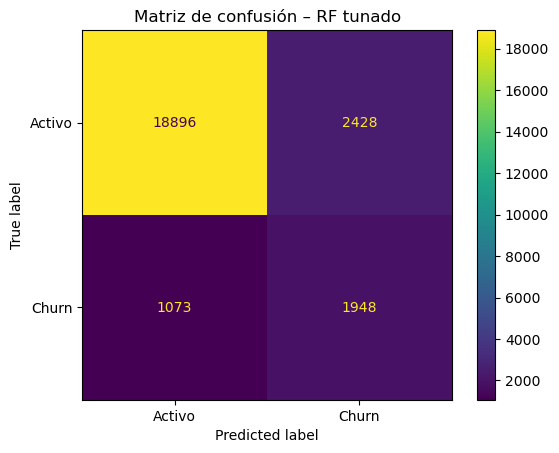

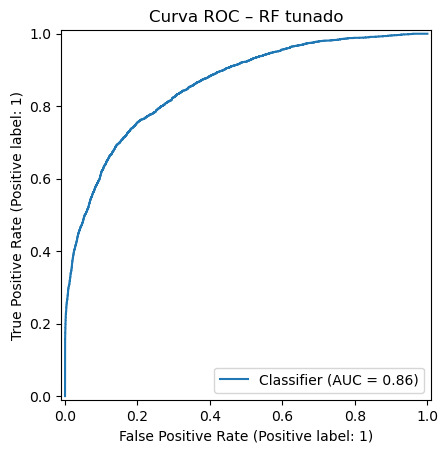

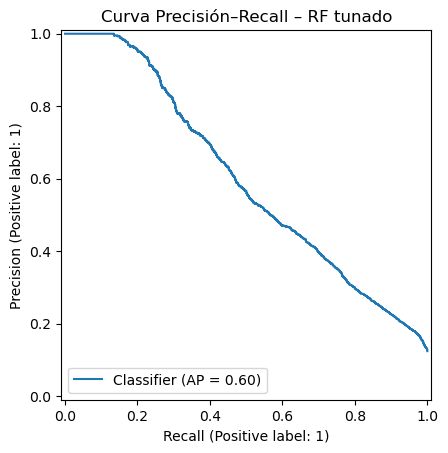

In [116]:
print("=== 28. Gráficos de performance – RF tunado ===")

import matplotlib.pyplot as plt
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(
    y_test_rf,
    y_pred_rf_final,
    display_labels=['Activo', 'Churn'],
)
plt.title("Matriz de confusión – RF tunado")
plt.show()

# Curva ROC
RocCurveDisplay.from_predictions(
    y_test_rf,
    y_proba_rf_final
)
plt.title("Curva ROC – RF tunado")
plt.show()

# Curva Precisión–Recall
PrecisionRecallDisplay.from_predictions(
    y_test_rf,
    y_proba_rf_final
)
plt.title("Curva Precisión–Recall – RF tunado")
plt.show()


## 29. Top variables más importantes del modelo final

Finalmente, muestro un gráfico con las variables más importantes según el Random Forest tunado.
Este gráfico es útil para explicar al negocio qué factores están más asociados al churn.


=== 29. Top variables más importantes – RF tunado ===


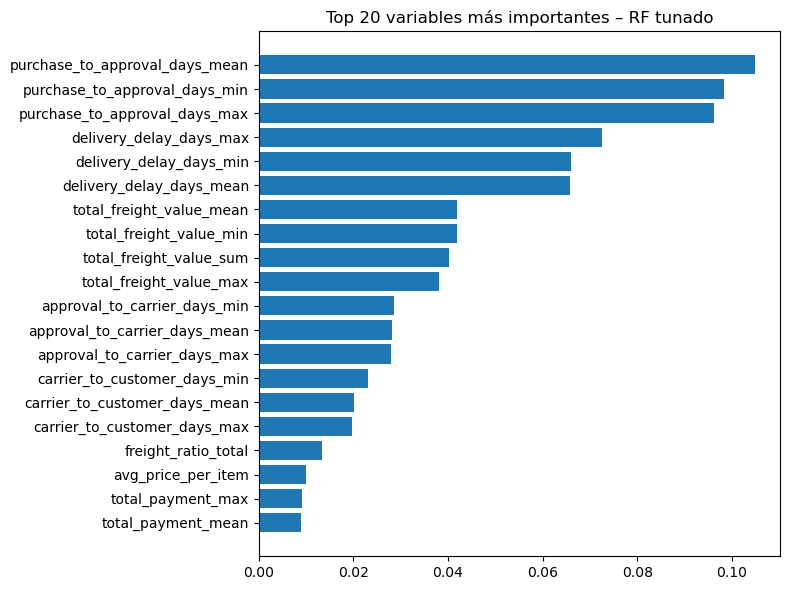

In [117]:
print("=== 29. Top variables más importantes – RF tunado ===")

top_n = 20  # puedes ajustar este número si quieres mostrar más o menos
top_imp_final = importances_final.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_imp_final.index, top_imp_final.values)
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} variables más importantes – RF tunado")
plt.tight_layout()
plt.show()
